In [2]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

### Load data

In [3]:
df = pd.read_csv("../data/clean/main_df.csv")

### Turn string values into numerical ones

In [4]:
# Convert "playoff" column to binary (Y: 1, N: 0)
df["playoff"] = df["playoff"].map({"Y": 1, "N": 0})

def map_strings_to_int(df, col):
    """
    Maps string values to integers
    """
    values = df[col].unique()
    mapping = {value: i for i, value in enumerate(values)}
    df[col] = df[col].map(mapping)

map_strings_to_int(df, "tmID")
map_strings_to_int(df, "playerID")
map_strings_to_int(df, "coachID")
map_strings_to_int(df, "pos")

df.to_csv("../data/clean/pre.csv", index=False)

print(df['tmID'].to_frame())


      tmID
0        0
1        0
2        0
3        0
4        0
...    ...
2155    19
2156    19
2157    19
2158    19
2159    19

[2160 rows x 1 columns]


### Training and evaluation function

In [37]:
from dataclasses import dataclass

@dataclass
class Result:
    year: int
    accuracy: float
    auc: float

results = {}

def classification(model, df, min_year, max_year):
    for i in range(min_year, max_year + 1):
        df_train = df[df['year'] < i]
        df_test = df[df['year'] == i]

        X_train = df_train.drop("playoff", axis=1)  # Features
        y_train = df_train["playoff"]  # Target variable

        X_test = df_test.drop("playoff", axis=1)  # Features
        y_test = df_test["playoff"]  # Target variable

        print(f"\nTrain/Test size for year={i}:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        model.fit(X_train, y_train)

        # Predict the response for the test dataset
        y_pred = model.predict(X_test)

        print(f"\nyear = {i}, Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
        print(f"\nyear = {i}, Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(f"\nyear = {i}, AUC: ", roc_auc_score(y_test, y_pred))
        print(f"\nyear = {i}, Accuracy: ", accuracy_score(y_test, y_pred))

        result = Result(
            year=i,
            accuracy=accuracy_score(y_test, y_pred),
            auc=roc_auc_score(y_test, y_pred),
        )

        if (str(model) not in results):
            results[str(model)] = []
        results[str(model)].append(result)

### Define values for min_year and max_year

In [34]:
min_year = 2
max_year = df['year'].max()

### Decision Tree


Train/Test size for year=2: (222, 94) (235, 94) (222,) (235,)

year = 2, Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       107
           1       1.00      1.00      1.00       128

    accuracy                           1.00       235
   macro avg       1.00      1.00      1.00       235
weighted avg       1.00      1.00      1.00       235


year = 2, Confusion Matrix:
 [[107   0]
 [  0 128]]

year = 2, AUC:  1.0

year = 2, Accuracy:  1.0

Train/Test size for year=3: (457, 94) (261, 94) (457,) (261,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       108

    accuracy                           1.00       261
   macro avg       1.00      1.00      1.00       261
weighted avg       1.00      1.00      1.00       261


year = 3, Confusion Matrix:
 [[153   0]
 [  0 108

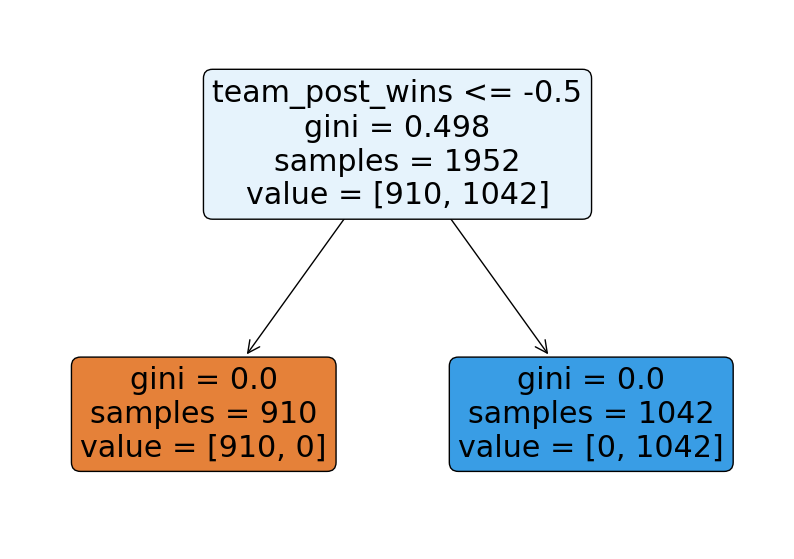

In [35]:
model = DecisionTreeClassifier(random_state=42)
classification(model, df, min_year, max_year)

from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plot_tree(model, filled=True, feature_names=df.columns.to_list(), rounded=True)
plt.show()

### SVM

In [38]:
model = SVC(random_state=42)
classification(model, df, min_year, max_year)


Train/Test size for year=2: (222, 94) (235, 94) (222,) (235,)

year = 2, Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       107
           1       0.54      1.00      0.71       128

    accuracy                           0.54       235
   macro avg       0.77      0.50      0.35       235
weighted avg       0.75      0.54      0.38       235


year = 2, Confusion Matrix:
 [[  0 107]
 [  0 128]]

year = 2, AUC:  0.5

year = 2, Accuracy:  0.5446808510638298

Train/Test size for year=3: (457, 94) (261, 94) (457,) (261,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       153
           1       0.41      1.00      0.59       108

    accuracy                           0.41       261
   macro avg       0.71      0.50      0.29       261
weighted avg       0.76      0.41      0.24       261


year = 3, Confusion Matrix:
 [[  0

### Logistic Regression

In [41]:
model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
classification(model, df, min_year, max_year)


Train/Test size for year=2: (222, 94) (235, 94) (222,) (235,)

year = 2, Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.69      0.82       107
           1       0.80      1.00      0.89       128

    accuracy                           0.86       235
   macro avg       0.90      0.85      0.85       235
weighted avg       0.89      0.86      0.85       235


year = 2, Confusion Matrix:
 [[ 74  33]
 [  0 128]]

year = 2, AUC:  0.8457943925233645

year = 2, Accuracy:  0.8595744680851064

Train/Test size for year=3: (457, 94) (261, 94) (457,) (261,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89       153
           1       0.87      0.81      0.84       108

    accuracy                           0.87       261
   macro avg       0.87      0.86      0.86       261
weighted avg       0.87      0.87      0.87       261


year = 3, Confusion

### Random Forest

In [42]:
model = RandomForestClassifier(random_state=42)
classification(model, df, min_year, max_year)


Train/Test size for year=2: (222, 94) (235, 94) (222,) (235,)

year = 2, Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       107
           1       1.00      1.00      1.00       128

    accuracy                           1.00       235
   macro avg       1.00      1.00      1.00       235
weighted avg       1.00      1.00      1.00       235


year = 2, Confusion Matrix:
 [[107   0]
 [  0 128]]

year = 2, AUC:  1.0

year = 2, Accuracy:  1.0

Train/Test size for year=3: (457, 94) (261, 94) (457,) (261,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       108

    accuracy                           1.00       261
   macro avg       1.00      1.00      1.00       261
weighted avg       1.00      1.00      1.00       261


year = 3, Confusion Matrix:
 [[153   0]
 [  0 108

### Gradient Boosting Classifier

In [43]:
model = GradientBoostingClassifier()
classification(model, df, min_year, max_year)


Train/Test size for year=2: (222, 94) (235, 94) (222,) (235,)

year = 2, Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       107
           1       1.00      1.00      1.00       128

    accuracy                           1.00       235
   macro avg       1.00      1.00      1.00       235
weighted avg       1.00      1.00      1.00       235


year = 2, Confusion Matrix:
 [[107   0]
 [  0 128]]

year = 2, AUC:  1.0

year = 2, Accuracy:  1.0

Train/Test size for year=3: (457, 94) (261, 94) (457,) (261,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       108

    accuracy                           1.00       261
   macro avg       1.00      1.00      1.00       261
weighted avg       1.00      1.00      1.00       261


year = 3, Confusion Matrix:
 [[153   0]
 [  0 108

### K Neighbors

In [44]:
model = KNeighborsClassifier()
classification(model, df, min_year, max_year)


Train/Test size for year=2: (222, 94) (235, 94) (222,) (235,)

year = 2, Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.53      0.64       107
           1       0.70      0.90      0.78       128

    accuracy                           0.73       235
   macro avg       0.76      0.72      0.71       235
weighted avg       0.75      0.73      0.72       235


year = 2, Confusion Matrix:
 [[ 57  50]
 [ 13 115]]

year = 2, AUC:  0.7155738901869159

year = 2, Accuracy:  0.7319148936170212

Train/Test size for year=3: (457, 94) (261, 94) (457,) (261,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77       153
           1       0.68      0.62      0.65       108

    accuracy                           0.72       261
   macro avg       0.71      0.71      0.71       261
weighted avg       0.72      0.72      0.72       261


year = 3, Confusion

# Results

In [50]:
from pprint import pprint

# Extracting accuracy for the last year for each model
previous_year_accuracies = {model: results[model][-1].accuracy for model in results}

# Sorting the results by accuracy in descending order
sorted_results = dict(sorted(previous_year_accuracies.items(), key=lambda item: item[1], reverse=True))

# Printing the results
print("Train/test results for the last year of data:\n")
for model, accuracy in sorted_results.items():
    print(f"{model}: {accuracy:.4f}")

for model in results:
    for result in results[model]:
        if result.accuracy == 1:
            print(f"\n{model} has 100% accuracy for year {result.year}, possible data leakage")

Train/test results for the last year of data:

RandomForestClassifier(random_state=42): 1.0000
GradientBoostingClassifier(): 1.0000
LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'): 0.9808
LogisticRegression(max_iter=100000, random_state=42, solver='newton-cg'): 0.8558
LogisticRegression(max_iter=1000, random_state=42, solver='newton-cg'): 0.8558
SVC(random_state=42): 0.6827
KNeighborsClassifier(): 0.5433

LogisticRegression(max_iter=100000, random_state=42, solver='newton-cg') has 100% accuracy for year 9, possible data leakage

LogisticRegression(max_iter=1000, random_state=42, solver='newton-cg') has 100% accuracy for year 9, possible data leakage

RandomForestClassifier(random_state=42) has 100% accuracy for year 2, possible data leakage

RandomForestClassifier(random_state=42) has 100% accuracy for year 3, possible data leakage

RandomForestClassifier(random_state=42) has 100% accuracy for year 4, possible data leakage

RandomForestClassifier(random_state=42)